In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')



In [2]:
# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

2024-09-25 11:18:42.640253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 11:18:42.640354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 11:18:42.799738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **import csv dataset**

In [3]:
data = pd.read_csv("/kaggle/input/faces-age-detection-dataset/faces/train.csv", index_col = 0)
print(data.head())
print(data.shape)

            Class
ID               
377.jpg    MIDDLE
17814.jpg   YOUNG
21283.jpg  MIDDLE
16496.jpg   YOUNG
4487.jpg   MIDDLE
(19906, 1)


In [4]:
data['Class'].value_counts()

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

<Axes: >

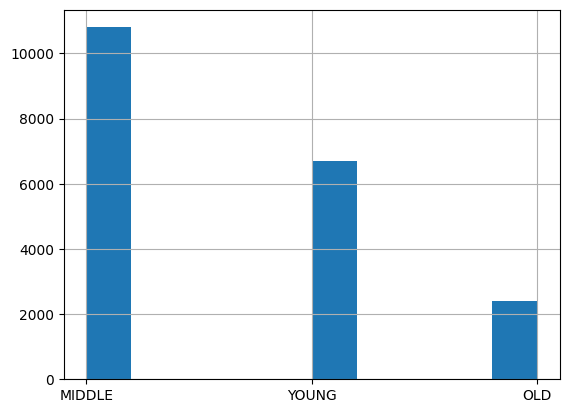

In [5]:
# Create a histogram for all categories in the class variable.
data['Class'].hist()


# **load images dataset**

**creates a list of file paths for images, combines these paths with their labels in a table, and then shows how many images are in each category before dividing the data for training and testing.**




In [6]:
# Create file paths using the index (ID)
directory = "/kaggle/input/faces-age-detection-dataset/faces/Train/"
data['filepath'] = directory + data.index
print(data.head())


            Class                                           filepath
ID                                                                  
377.jpg    MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
17814.jpg   YOUNG  /kaggle/input/faces-age-detection-dataset/face...
21283.jpg  MIDDLE  /kaggle/input/faces-age-detection-dataset/face...
16496.jpg   YOUNG  /kaggle/input/faces-age-detection-dataset/face...
4487.jpg   MIDDLE  /kaggle/input/faces-age-detection-dataset/face...


In [7]:

# Create DataFrame with filepath and class labels
df_train = data[['filepath', 'Class']].rename(columns={'Class': 'label'})
print(df_train.head())

# Check class distribution before splitting
print("Class distribution before splitting:")
print(df_train['label'].value_counts())
print(df_train.shape)

                                                    filepath   label
ID                                                                  
377.jpg    /kaggle/input/faces-age-detection-dataset/face...  MIDDLE
17814.jpg  /kaggle/input/faces-age-detection-dataset/face...   YOUNG
21283.jpg  /kaggle/input/faces-age-detection-dataset/face...  MIDDLE
16496.jpg  /kaggle/input/faces-age-detection-dataset/face...   YOUNG
4487.jpg   /kaggle/input/faces-age-detection-dataset/face...  MIDDLE
Class distribution before splitting:
label
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64
(19906, 2)


**splits a dataset into three parts for machine learning: training (80%), validation (10%), and testing (10%). It uses a fixed random seed to ensure consistent splits each time. After dividing, it prints the sizes of each dataset to confirm the split was done correctly. It also checks how the classes are distributed within the training data to understand the data's balance. This process helps in preparing data for building and evaluating machine learning models.**

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test (10%) sets
train_df, dummy_df = train_test_split(df_train, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)

# Print the shapes of the datasets
print(f"The shape of the Train data is: {train_df.shape}")
print(f"The shape of the Validation data is: {valid_df.shape}")
print(f"The shape of the Test data is: {test_df.shape}")

# Check class distribution in train_df
print("Class distribution in the Train data:")
print(train_df['label'].value_counts())


The shape of the Train data is: (15924, 2)
The shape of the Validation data is: (1991, 2)
The shape of the Test data is: (1991, 2)
Class distribution in the Train data:
label
MIDDLE    8623
YOUNG     5376
OLD       1925
Name: count, dtype: int64


**converts the integer labels in the train_df, valid_df, and test_df DataFrames to strings. It ensures that the labels are represented as strings, which is often necessary for certain data processing tasks or when working with specific machine learning algorithms that require categorical data in string format**

In [9]:

# Convert integer labels to strings for the data generators
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


**This function bgr_to_rgb changes an image from BGR (used by OpenCV) to RGB format. It's useful for making sure colors display correctly in applications that need RGB input, like many Python image libraries.**


In [10]:

# Custom function to convert BGR to RGB
def bgr_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# **DATA AUGMENTATION**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**This code sets up data generators for training, validation, and testing with images. The `train_datagen` applies augmentation like shearing, zooming, and horizontal flipping to the training data, while `validation_test_datagen` only rescales pixel values for validation and test datasets. Each generator is configured to read image paths and corresponding labels from DataFrames (`train_df`, `valid_df`, `test_df`). Images are resized to 256x256 pixels, converted to categorical labels, and batched into groups of 80 for efficient processing. Finally, it prints the class indices to verify how classes are mapped for model training.**



In [12]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator without augmentation
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 80

# Create data generators
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Check the class indices to ensure they are correct
print("Class indices:", train_ds.class_indices)

Training Data
Found 15924 validated image filenames belonging to 3 classes.
Validation Data
Found 1991 validated image filenames belonging to 3 classes.
Test Data
Found 1991 validated image filenames belonging to 3 classes.
Class indices: {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


In [13]:
# # Count the occurrences of each category in the 'category' column
# count = df_train['label'].value_counts()

# # Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# # Plot pie chart on the first subplot
# palette = sns.color_palette("viridis")
# sns.set_palette(palette)
# axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
# axs[0].set_title('Distribution of Categories')

# # Plot bar chart on the second subplot
# sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
# axs[1].set_title('Count of Categories')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

**display_random_images selects and shows a specified number of random images from a dataset. It takes a generator (train_ds in this case) that provides batches of images and labels. It retrieves a batch of data, selects random indices from the batch, and displays the corresponding images with their labels in a row of plots. Each plot includes an image with its associated label displayed as the title. The function ensures the images are shown without axis ticks for clearer presentation and adjusts the layout before displaying them.**



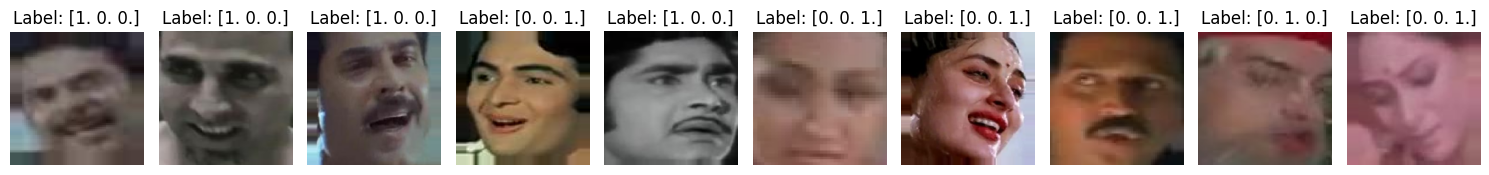

In [14]:
# Function to select and display random images
def display_random_images(generator, num_images):
    # Get batch of images and labels
    batch = next(generator)

    # Select random images from the batch
    selected_indices = random.sample(range(len(batch[0])), min(num_images, len(batch[0])))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, idx in enumerate(selected_indices):
        image = batch[0][idx]  # Get the image array from batch
        label = batch[1][idx]  # Get the corresponding label
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")  # Set label as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Assuming train_generator is your NumpyArrayIterator for the training set
# Display 5 random images from the training set
display_random_images(train_ds, 10)

**`class_labels` is assigned the class indices generated by `train_ds.class_indices`, mapping class names to numerical identifiers for AGE DETECTION classification The `print` statement displays the class labels and their respective indices, facilitating verification and usage during the classification process.**

In [15]:
# Define the class labels for AGE DETECTION classification
class_labels = train_ds.class_indices

# Print the class labels
print(f'Class labels: {class_labels}')

Class labels: {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


# **IMPORT PRETRAINED MODEL XCEPTION**

In [16]:
from tensorflow.keras.applications import Xception 


In [17]:
conv_base = Xception (
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Build Model
model = Sequential()

# Base Model
model.add(conv_base)

# Add Global Average Pooling to flatten the output from the base model
model.add(GlobalAveragePooling2D())

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Dense Layer 2
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer (number of classes should match your dataset)
model.add(Dense(3, activation='softmax'))  # Change the number of units to match the number of classes

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
import tensorflow as tf


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

In [22]:
history = model.fit(train_ds, epochs=50, validation_data=validation_ds,callbacks=[early_stopping])


Epoch 1/50


2024-09-25 11:23:31.320206: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[80,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-25 11:23:31.833779: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.513766043s
Trying algorithm eng3{k11=2} for conv (f32[80,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking 

187/200 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5289 - loss: 6.5216

W0000 00:00:1727263868.168134      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5340 - loss: 6.4248

W0000 00:00:1727263892.768332      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-09-25 11:31:59.615048: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[71,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[71,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-25 11:31:59.975858: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.360912307s
Trying algorithm eng3{k11=2} for conv (f32[71,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[71,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convF

200/200 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.5344 - loss: 6.4175 - val_accuracy: 0.6926 - val_loss: 2.5577
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.7164 - loss: 2.1199 - val_accuracy: 0.7383 - val_loss: 1.4690
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.7726 - loss: 1.0486 - val_accuracy: 0.6494 - val_loss: 1.1011
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.8166 - loss: 0.7583 - val_accuracy: 0.7976 - val_loss: 0.6147
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.8532 - loss: 0.5014 - val_accuracy: 0.7172 - val_loss: 0.8031
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.8117 - loss: 0.6254 - val_accuracy: 0.6404 - val_loss: 0.9100
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.8396 - loss: 0.4877 - val_accuracy: 0.7589 - val_loss: 0.7339
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.8702 - loss: 0.4101 - val_accuracy: 0.653

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy:', accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.8324 - loss: 0.4612
Test accuracy: 0.8387745022773743


In [24]:
pred = model.predict(test_ds)


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:16 3s/step

W0000 00:00:1727269000.483714      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 832ms/step


W0000 00:00:1727269020.439012      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step


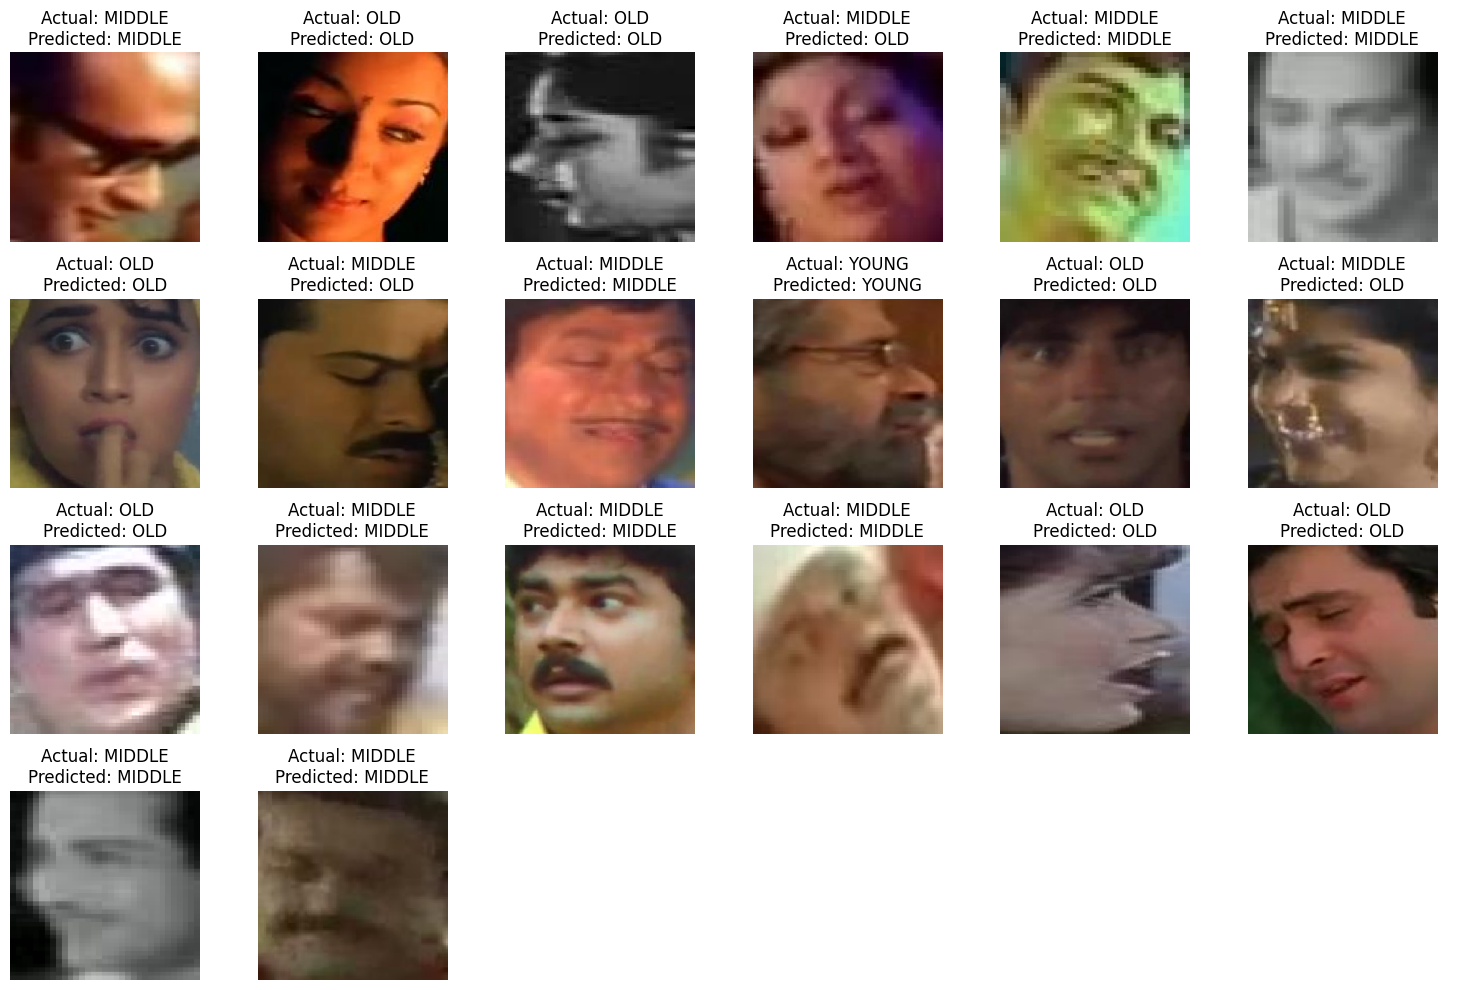

In [25]:
# Number of images to display
num_images_to_display = 20

# Fetch a batch of test data from the test dataset generator (test_ds)
x_test, y_test = next(iter(test_ds))
x_test = x_test[:num_images_to_display]
y_test = y_test[:num_images_to_display]

# Get predictions for the batch of test images
pred = model.predict(test_ds)
pred_classes = np.argmax(pred, axis=1)

# Define class names
classes = ['MIDDLE','YOUNG','OLD'] 

# Number of columns for the subplot grid
num_columns = 6
num_rows = (num_images_to_display + num_columns - 1) // num_columns

# Plot the images with actual and predicted labels
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(x_test):
        ax.imshow(x_test[i])
        actual_label = classes[np.argmax(y_test[i])]  # Convert one-hot to index
        predicted_label = classes[pred_classes[i]]
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

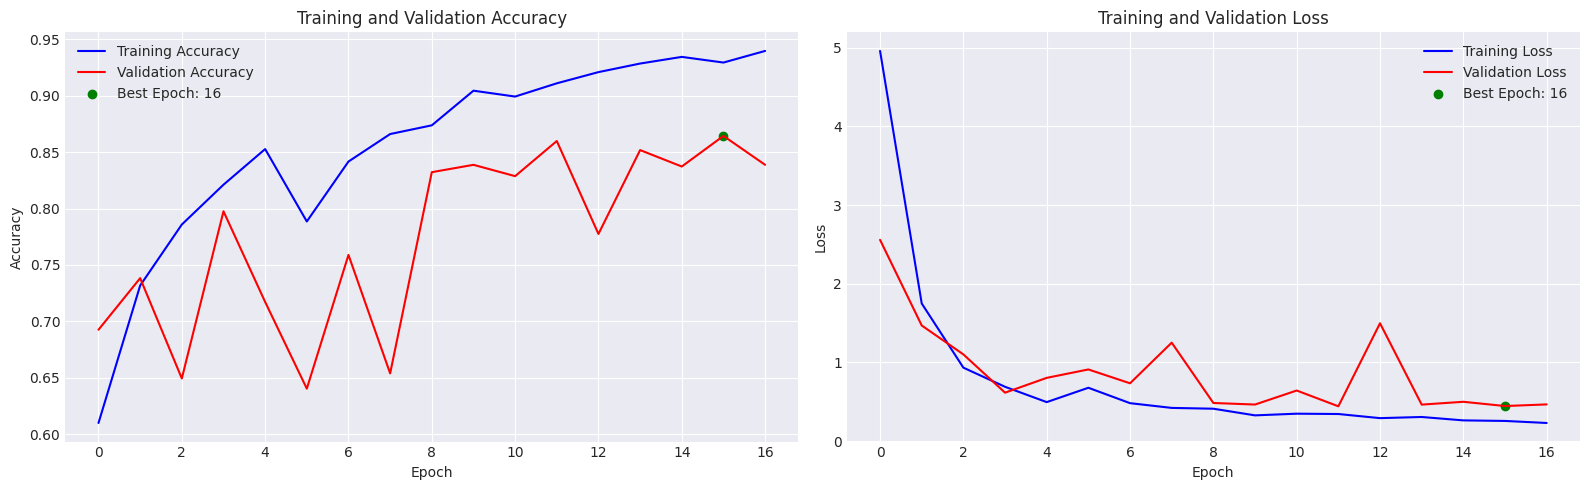

In [26]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()